In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import os
from sklearn.metrics import confusion_matrix

In [3]:
import xgboost as xgb
from xgboost import plot_importance

In [4]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 125)

In [5]:
model_path_name = "all_features_model_fully_tuned"
DIRECTORY_PATH = f"models/{model_path_name}"
MODEL_INFO_FILEPATH = f"{DIRECTORY_PATH}/info.txt"

In [6]:
dataset = pd.read_pickle("datasets/dummy_dataset.pkl")

train_index_stop = 15893 # this is the first index of a new pitcher
val_index_stop = 17898 # make sure no overlapping plays

training_set = dataset.iloc[0:train_index_stop, :]
validation_set = dataset.iloc[train_index_stop:val_index_stop, :]
test_set = dataset.iloc[val_index_stop:,]

train_X = training_set.drop(["GAMEID", "PLAYID", "RUNPASS"],axis=1)
train_y = training_set['RUNPASS']

val_X = validation_set.drop(["GAMEID", "PLAYID", "RUNPASS"],axis=1)
val_y = validation_set['RUNPASS']

test_X = test_set.drop(["GAMEID", "PLAYID", "RUNPASS"],axis=1)
test_y = test_set['RUNPASS']

mapping = {'R' : 0,
           'P': 1
           }
train_y = train_y.map(mapping)
val_y = val_y.map(mapping)
test_y = test_y.map(mapping)

In [7]:
clf = pickle.load(open(f"{DIRECTORY_PATH}/xgb_model.pkl", "rb"))

In [7]:
# https://stackoverflow.com/questions/37340474/xgb-plot-tree-font-size-python
def plot_tree(xgb_model, filename, rankdir='UT', tree_num=0):
    """
    Plot the tree in high resolution
    :param xgb_model: xgboost trained model
    :param filename: the pdf file where this is saved
    :param rankdir: direction of the tree: default Top-Down (UT), accepts:'LR' for left-to-right tree
    :return:
    """
    
    gvz = xgb.to_graphviz(xgb_model, num_trees=tree_num, rankdir=rankdir)
    _, file_extension = os.path.splitext(filename)
    format = file_extension.strip('.').lower()
    data = gvz.pipe(format=format)
    full_filename = filename
    with open(full_filename, 'wb') as f:
        f.write(data)

In [59]:
# for tree_number in range(1,6):
#     plot_tree(clf, f"{DIRECTORY_PATH}/tree_graph_{tree_number}.pdf", tree_num=tree_number)

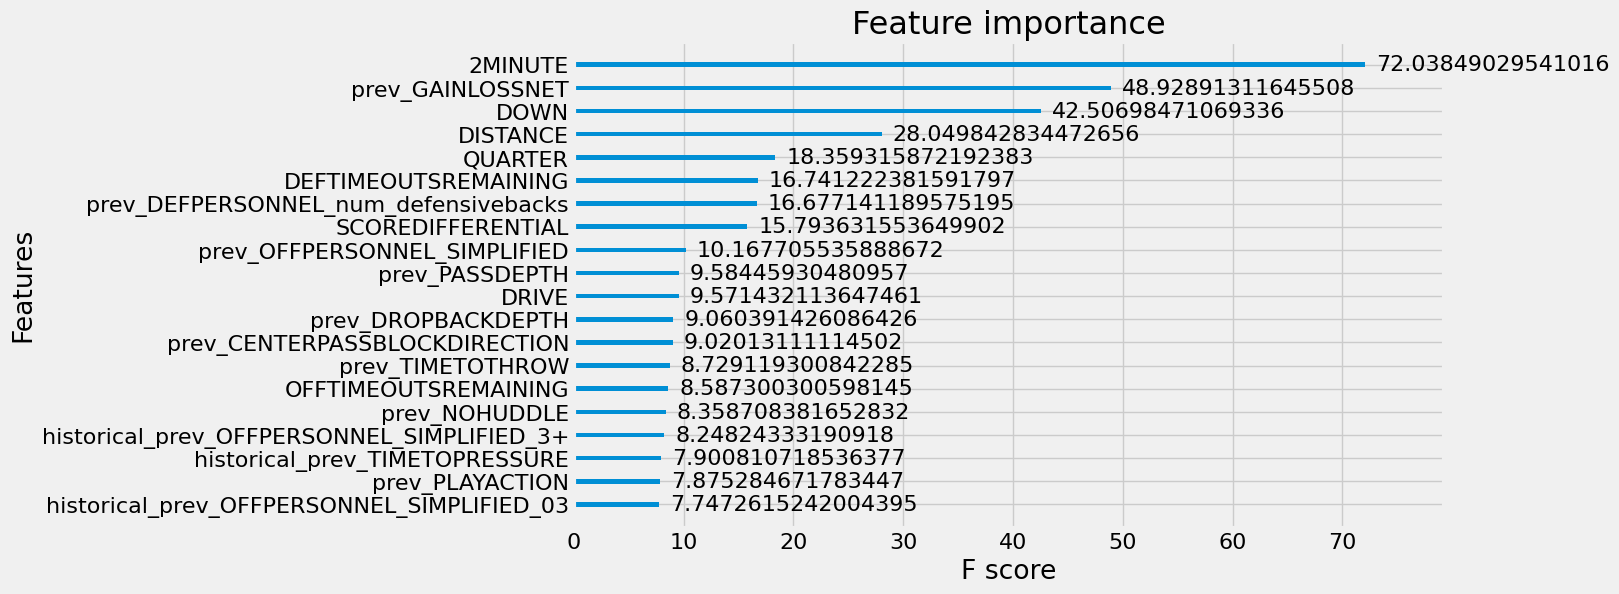

In [8]:
plt.style.use('fivethirtyeight')
plt.rcParams.update({'font.size': 16})

fig, ax1 = plt.subplots(1,1, figsize=(10,6))
plot_importance(clf, importance_type='gain', max_num_features=20, ax=ax1)
plt.show()

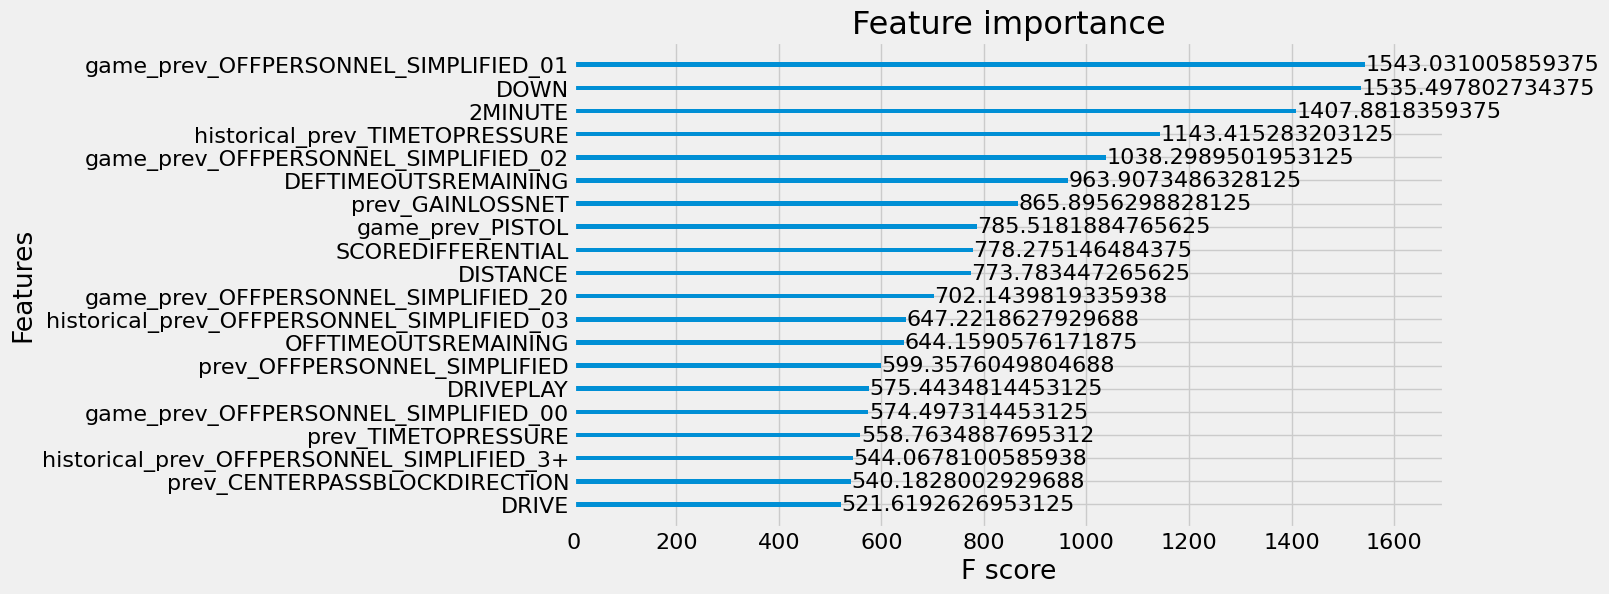

In [57]:
plt.style.use('fivethirtyeight')
plt.rcParams.update({'font.size': 16})

fig, ax1 = plt.subplots(1,1, figsize=(10,6))
plot_importance(clf, importance_type='cover', max_num_features=20, ax=ax1)
plt.savefig("images/feature_importance/cover_feature_importance_final_model.png", bbox_inches = 'tight')
plt.show()

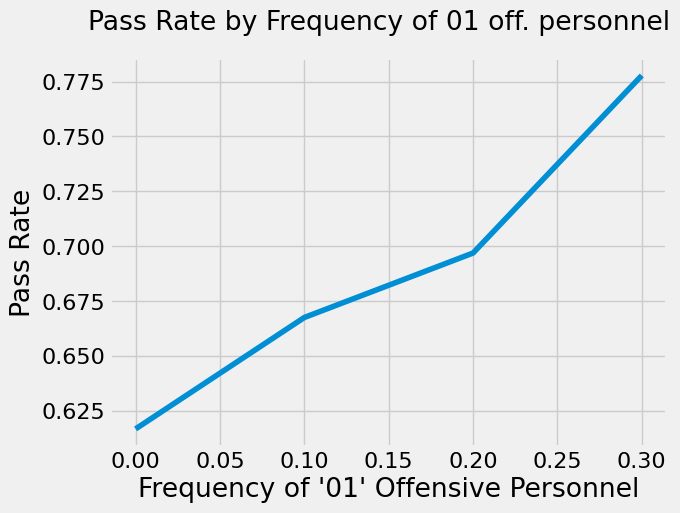

In [58]:
fig, ax = plt.subplots()

vals = np.linspace(0,5,6)/10
y = [dataset.query("game_prev_OFFPERSONNEL_SIMPLIFIED_01 >= @val and game_prev_OFFPERSONNEL_SIMPLIFIED_01 <= (@val + 0.1)").RUNPASS.map({"P":1, "R":0}).astype(int).mean() for val in vals]
plt.plot(vals, y)
fig.suptitle("Pass Rate by Frequency of 01 off. personnel")
plt.xlabel("Frequency of '01' Offensive Personnel")
plt.ylabel("Pass Rate")
plt.savefig("images/feature_importance/pass_rate_by_01_personnel.png", bbox_inches = 'tight')
plt.show()

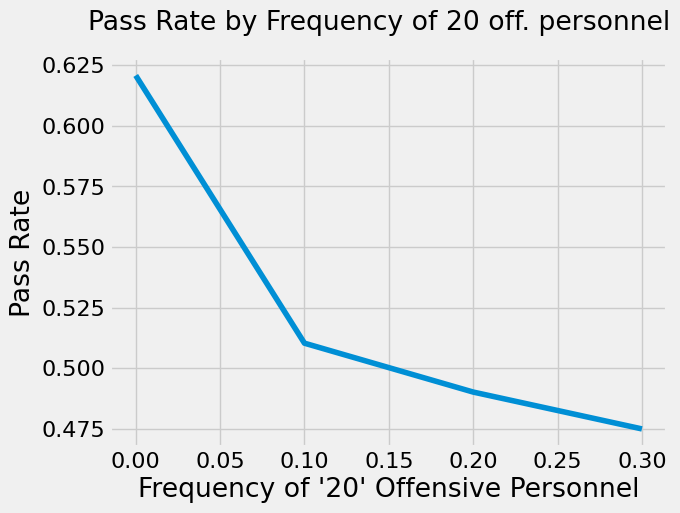

In [59]:
fig, ax = plt.subplots()

vals = np.linspace(0,5,6)/10
y = [dataset.query("game_prev_OFFPERSONNEL_SIMPLIFIED_20 >= @val and game_prev_OFFPERSONNEL_SIMPLIFIED_20 <= (@val + 0.1)").RUNPASS.map({"P":1, "R":0}).astype(int).mean() for val in vals]
plt.plot(vals, y)
fig.suptitle("Pass Rate by Frequency of 20 off. personnel")
plt.xlabel("Frequency of '20' Offensive Personnel")
plt.ylabel("Pass Rate")
plt.savefig("images/feature_importance/pass_rate_by_20_personnel.png", bbox_inches = 'tight')
plt.show()

In [31]:
dataset[(dataset.prev_GAINLOSSNET < 5)].RUNPASS.value_counts()

RUNPASS
P    6459
R    2330
Name: count, dtype: int64

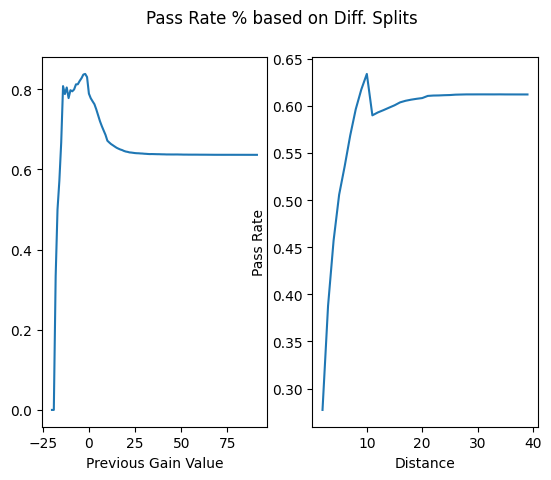

In [46]:
fig, (ax1, ax2) = plt.subplots(1,2)

gain_values = np.sort(dataset.prev_GAINLOSSNET.dropna().unique())
y_gain = [dataset[(dataset.prev_GAINLOSSNET < gain_val)].RUNPASS.map({"P":1, "R":0}).astype(int).mean() for gain_val in gain_values]
ax1.plot(gain_values, y_gain)

distances = np.sort(dataset.DISTANCE.dropna().unique())
y_dist = [dataset[(dataset.DISTANCE < dist)].RUNPASS.map({"P":1, "R":0}).astype(int).mean() for dist in distances]
ax2.plot(distances, y_dist)

fig.suptitle(f"Pass Rate % based on Diff. Splits")
ax1.set_xlabel("Previous Gain Value")
ax2.set_xlabel("Distance")
plt.ylabel("Pass Rate")
plt.savefig("images/tree_analysis/pass_rates_by_splits.png")
plt.show()


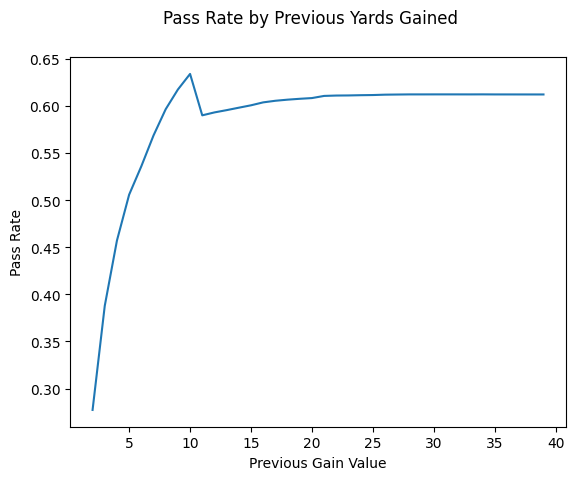

In [39]:
fig, ax = plt.subplots()

distances = np.sort(dataset.DISTANCE.dropna().unique())
y = [dataset[(dataset.DISTANCE < dist)].RUNPASS.map({"P":1, "R":0}).astype(int).mean() for dist in distances]
plt.plot(distances, y)

fig.suptitle("Pass Rate by Distance")
plt.xlabel("Previous Gain Value")
plt.ylabel("Pass Rate")
#plt.savefig("images/tree_analysis/pass_rate_by_prev_yards_gained_line_chart.png")
plt.show()

In [52]:
dataset[(dataset.prev_GAINLOSSNET >= 5) & (dataset.DISTANCE < 2)].RUNPASS.value_counts()

RUNPASS
R    489
P    193
Name: count, dtype: int64

In [50]:
dataset[(dataset.DISTANCE < 2)].RUNPASS.value_counts(normalize=True)

RUNPASS
R    0.722711
P    0.277289
Name: proportion, dtype: float64

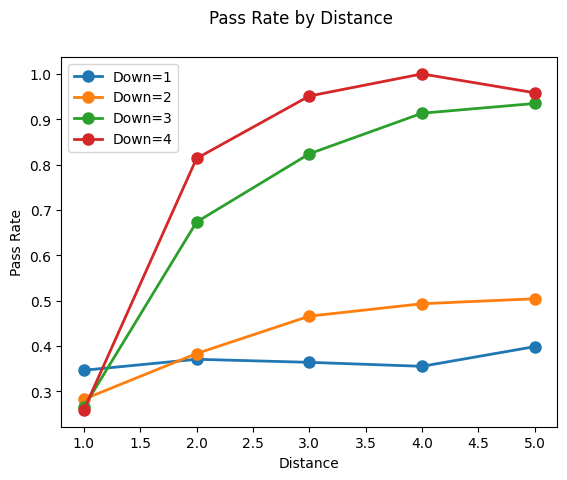

In [56]:
fig, ax = plt.subplots()

downs = dataset.DOWN.unique()
distances = np.sort(dataset.DISTANCE.unique())[0:5]
for down in downs:
    down_df = dataset[dataset.DOWN == down]
    y = [down_df.query("DISTANCE == @dist").RUNPASS.map({"P":1, "R":0}).astype(int).mean() for dist in distances]
    widths = np.array([down_df.query("DISTANCE == @dist").shape[0] for dist in distances])
    # #widths = widths/max(widths)
    ax.plot(distances, y, marker='o', linewidth=2, markersize=8,  label=f"Down={down}")
    
fig.suptitle("Pass Rate by Distance")

plt.legend()
plt.xlabel("Distance")
plt.ylabel("Pass Rate")
plt.savefig("images/tree_analysis/pass_rate_by_distances_to_five.png")
plt.show()

In [26]:
dataset[(dataset.prev_GAINLOSSNET >= 5) & (dataset['2MINUTE'] < 2) & (dataset.DOWN != 3) & (dataset.DISTANCE < 2)].RUNPASS.value_counts()

RUNPASS
R    291
P     95
Name: count, dtype: int64

In [15]:
dataset[(dataset.prev_GAINLOSSNET >= 5) & (dataset['2MINUTE'] < 2) & (dataset.DOWN == 3) & (dataset.DISTANCE < 2)].RUNPASS.value_counts()

RUNPASS
R    149
P     47
Name: count, dtype: int64

In [20]:
train_y[train_X[(train_X.prev_GAINLOSSNET >= 5) & (train_X['2MINUTE'] < 2) & (train_X.DOWN == 3) & (train_X.DISTANCE < 2)].index].value_counts()

RUNPASS
0    127
1     40
Name: count, dtype: int64

In [21]:
test_y[test_X[(test_X.prev_GAINLOSSNET >= 5) & (test_X['2MINUTE'] < 2) & (test_X.DOWN == 3) & (test_X.DISTANCE < 2)].index].value_counts()

RUNPASS
0    8
1    2
Name: count, dtype: int64

In [ ]:
''' 
Look at model outputs from validation_set
'''

In [46]:
validation_set_with_probs = validation_set.copy(deep=True)

In [47]:
y_pred = clf.predict(val_X)
y_probs = clf.predict_proba(val_X)

print('\n------------------ Confusion Matrix -----------------\n')
cmatrix = confusion_matrix(val_y, y_pred)
print(f"{pd.DataFrame(cmatrix, columns=list(mapping.keys()), index=list(mapping.keys()))}")



------------------ Confusion Matrix -----------------

     R     P
R  394   355
P  220  1036


In [48]:
validation_set_with_probs['prediction'] = y_pred
validation_set_with_probs['prob_RUN'] = y_probs[:,0]
validation_set_with_probs['RUNPASS'] = validation_set_with_probs['RUNPASS'].map({"R":0, "P":1})
validation_set_with_probs['correct'] = (validation_set_with_probs['prediction'] == validation_set_with_probs['RUNPASS']).astype(int)
validation_set_with_probs = validation_set_with_probs[['prob_RUN', 'prediction', 'RUNPASS', 'correct'] + list(validation_set_with_probs.columns[0:-4])]

In [49]:
validation_set_with_probs.head()

,prob_RUN,prediction,RUNPASS,correct,GAMEID,PLAYID,WEEK,QUARTER,SCOREDIFFERENTIAL,SCORE,DISTANCE,DOWN,FIELDPOSITION,DRIVE,DRIVEPLAY,OFFTIMEOUTSREMAINING,DEFTIMEOUTSREMAINING,HASH,SPOTLEFT,2MINUTE,CLOCK_INT,prev_FORCEDFUMBLE,prev_HIT,prev_HURRY,prev_GAINLOSSNET,prev_INTERCEPTION,prev_NOHUDDLE,prev_PENALTY,prev_PASSDEPTH,prev_PASSBREAKUP,prev_DROPBACKDEPTH,prev_MOFO_PLAYED,prev_MOFO_SHOWN,prev_DEFPERSONNEL_num_linemen,prev_DEFPERSONNEL_num_linebackers,prev_DEFPERSONNEL_num_defensivebacks,prev_PISTOL,prev_PLAYACTION,prev_SACK,prev_SCREEN,prev_SHIFTMOTION,prev_SHOTGUN,prev_QBMOVEDOFFSPOT,prev_QBPRESSURE,prev_TIMETOPRESSURE,prev_TIMETOTHROW,prev_YARDSAFTERCATCH,prev_YARDSAFTERCONTACT,game_prev_FORCEDFUMBLE,game_prev_HIT,game_prev_HURRY,game_prev_GAINLOSSNET,game_prev_INTERCEPTION,game_prev_NOHUDDLE,game_prev_PENALTY,game_prev_PASSDEPTH,game_prev_PASSBREAKUP,game_prev_DROPBACKDEPTH,game_prev_MOFO_PLAYED,game_prev_MOFO_SHOWN,game_prev_DEFPERSONNEL_num_linemen,game_prev_DEFPERSONNEL_num_linebackers,game_prev_DEFPERSONNEL_num_defensivebacks,game_prev_PISTOL,game_prev_PLAYACTION,game_prev_SACK,game_prev_SCREEN,game_prev_SHIFTMOTION,game_prev_SHOTGUN,game_prev_QBMOVEDOFFSPOT,game_prev_QBPRESSURE,game_prev_TIMETOPRESSURE,game_prev_TIMETOTHROW,game_prev_YARDSAFTERCATCH,game_prev_YARDSAFTERCONTACT,historical_prev_FORCEDFUMBLE,historical_prev_HIT,historical_prev_HURRY,historical_prev_GAINLOSSNET,historical_prev_INTERCEPTION,historical_prev_NOHUDDLE,historical_prev_PENALTY,historical_prev_PASSDEPTH,historical_prev_PASSBREAKUP,historical_prev_DROPBACKDEPTH,historical_prev_MOFO_PLAYED,historical_prev_MOFO_SHOWN,historical_prev_DEFPERSONNEL_num_linemen,historical_prev_DEFPERSONNEL_num_linebackers,historical_prev_DEFPERSONNEL_num_defensivebacks,historical_prev_PISTOL,historical_prev_PLAYACTION,historical_prev_SACK,historical_prev_SCREEN,historical_prev_SHIFTMOTION,historical_prev_SHOTGUN,historical_prev_QBMOVEDOFFSPOT,historical_prev_QBPRESSURE,historical_prev_TIMETOPRESSURE,historical_prev_TIMETOTHROW,historical_prev_YARDSAFTERCATCH,historical_prev_YARDSAFTERCONTACT,prev_OFFPERSONNEL_SIMPLIFIED,prev_CENTERPASSBLOCKDIRECTION,game_prev_OFFPERSONNEL_SIMPLIFIED_11,game_prev_OFFPERSONNEL_SIMPLIFIED_21,game_prev_OFFPERSONNEL_SIMPLIFIED_12,game_prev_OFFPERSONNEL_SIMPLIFIED_22,game_prev_OFFPERSONNEL_SIMPLIFIED_01,game_prev_OFFPERSONNEL_SIMPLIFIED_02,game_prev_OFFPERSONNEL_SIMPLIFIED_13,game_prev_OFFPERSONNEL_SIMPLIFIED_10,game_prev_OFFPERSONNEL_SIMPLIFIED_20,game_prev_OFFPERSONNEL_SIMPLIFIED_23,game_prev_OFFPERSONNEL_SIMPLIFIED_3+,game_prev_OFFPERSONNEL_SIMPLIFIED_03,game_prev_OFFPERSONNEL_SIMPLIFIED_nan,game_prev_OFFPERSONNEL_SIMPLIFIED_00,game_prev_OFFPERSONNEL_SIMPLIFIED_14,game_prev_CENTERPASSBLOCKDIRECTION_L,game_prev_CENTERPASSBLOCKDIRECTION_C,game_prev_CENTERPASSBLOCKDIRECTION_R,game_prev_CENTERPASSBLOCKDIRECTION_nan,historical_prev_OFFPERSONNEL_SIMPLIFIED_11,historical_prev_OFFPERSONNEL_SIMPLIFIED_21,historical_prev_OFFPERSONNEL_SIMPLIFIED_12,historical_prev_OFFPERSONNEL_SIMPLIFIED_22,historical_prev_OFFPERSONNEL_SIMPLIFIED_01,historical_prev_OFFPERSONNEL_SIMPLIFIED_02,historical_prev_OFFPERSONNEL_SIMPLIFIED_13,historical_prev_OFFPERSONNEL_SIMPLIFIED_10,historical_prev_OFFPERSONNEL_SIMPLIFIED_20,historical_prev_OFFPERSONNEL_SIMPLIFIED_23,historical_prev_OFFPERSONNEL_SIMPLIFIED_3+,historical_prev_OFFPERSONNEL_SIMPLIFIED_03,historical_prev_OFFPERSONNEL_SIMPLIFIED_nan,historical_prev_OFFPERSONNEL_SIMPLIFIED_00,historical_prev_OFFPERSONNEL_SIMPLIFIED_14,historical_prev_CENTERPASSBLOCKDIRECTION_L,historical_prev_CENTERPASSBLOCKDIRECTION_C,historical_prev_CENTERPASSBLOCKDIRECTION_R,historical_prev_CENTERPASSBLOCKDIRECTION_nan,historical_yards_per_carry,historical_yards_per_pass_attempt,historical_yards_allowed_per_carry,historical_yards_allowed_per_pass_attempt
15893,0.503117,0,0,1,19715,4184108,8,1,0,0.0,10,1,-25,1.0,1.0,3,3,R,29,0,900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,

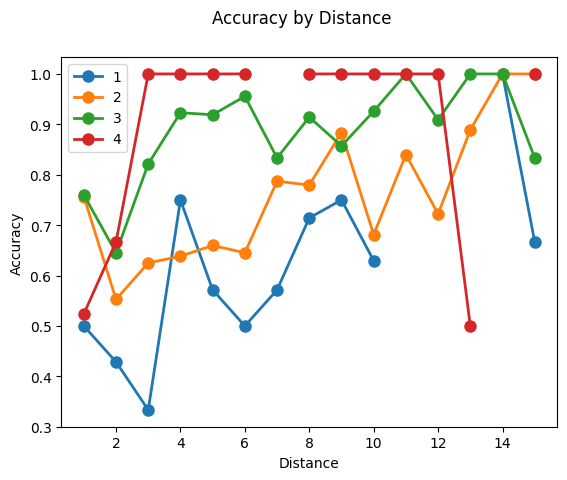

In [55]:
fig, ax = plt.subplots()

downs = validation_set_with_probs.DOWN.unique()
distances = np.sort(validation_set_with_probs.DISTANCE.unique())[0:15]
for down in downs:
    down_df = validation_set_with_probs[validation_set_with_probs.DOWN == down]
    y = [down_df.query("DISTANCE == @dist").correct.mean() for dist in distances]
    widths = np.array([down_df.query("DISTANCE == @dist").shape[0] for dist in distances])
    # #widths = widths/max(widths)
    ax.plot(distances, y, marker='o', linewidth=2, markersize=8,  label=f"{down}")
    
fig.suptitle("Accuracy by Distance")

plt.legend()
plt.xlabel("Distance")
plt.ylabel("Accuracy")
plt.savefig("images/results_model_inspection/val_acc_by_distance.png")
plt.show()

In [54]:
training_set.query("DOWN == 1 and DISTANCE == 3").RUNPASS.value_counts()

RUNPASS
R    17
P     8
Name: count, dtype: int64

In [52]:
validation_set_with_probs.query("DOWN == 1 and DISTANCE == 3")

,prob_RUN,prediction,RUNPASS,correct,GAMEID,PLAYID,WEEK,QUARTER,SCOREDIFFERENTIAL,SCORE,DISTANCE,DOWN,FIELDPOSITION,DRIVE,DRIVEPLAY,OFFTIMEOUTSREMAINING,DEFTIMEOUTSREMAINING,HASH,SPOTLEFT,2MINUTE,CLOCK_INT,prev_FORCEDFUMBLE,prev_HIT,prev_HURRY,prev_GAINLOSSNET,prev_INTERCEPTION,prev_NOHUDDLE,prev_PENALTY,prev_PASSDEPTH,prev_PASSBREAKUP,prev_DROPBACKDEPTH,prev_MOFO_PLAYED,prev_MOFO_SHOWN,prev_DEFPERSONNEL_num_linemen,prev_DEFPERSONNEL_num_linebackers,prev_DEFPERSONNEL_num_defensivebacks,prev_PISTOL,prev_PLAYACTION,prev_SACK,prev_SCREEN,prev_SHIFTMOTION,prev_SHOTGUN,prev_QBMOVEDOFFSPOT,prev_QBPRESSURE,prev_TIMETOPRESSURE,prev_TIMETOTHROW,prev_YARDSAFTERCATCH,prev_YARDSAFTERCONTACT,game_prev_FORCEDFUMBLE,game_prev_HIT,game_prev_HURRY,game_prev_GAINLOSSNET,game_prev_INTERCEPTION,game_prev_NOHUDDLE,game_prev_PENALTY,game_prev_PASSDEPTH,game_prev_PASSBREAKUP,game_prev_DROPBACKDEPTH,game_prev_MOFO_PLAYED,game_prev_MOFO_SHOWN,game_prev_DEFPERSONNEL_num_linemen,game_prev_DEFPERSONNEL_num_linebackers,game_prev_DEFPERSONNEL_num_defensivebacks,game_prev_PISTOL,game_prev_PLAYACTION,game_prev_SACK,game_prev_SCREEN,game_prev_SHIFTMOTION,game_prev_SHOTGUN,game_prev_QBMOVEDOFFSPOT,game_prev_QBPRESSURE,game_prev_TIMETOPRESSURE,game_prev_TIMETOTHROW,game_prev_YARDSAFTERCATCH,game_prev_YARDSAFTERCONTACT,historical_prev_FORCEDFUMBLE,historical_prev_HIT,historical_prev_HURRY,historical_prev_GAINLOSSNET,historical_prev_INTERCEPTION,historical_prev_NOHUDDLE,historical_prev_PENALTY,historical_prev_PASSDEPTH,historical_prev_PASSBREAKUP,historical_prev_DROPBACKDEPTH,historical_prev_MOFO_PLAYED,historical_prev_MOFO_SHOWN,historical_prev_DEFPERSONNEL_num_linemen,historical_prev_DEFPERSONNEL_num_linebackers,historical_prev_DEFPERSONNEL_num_defensivebacks,historical_prev_PISTOL,historical_prev_PLAYACTION,historical_prev_SACK,historical_prev_SCREEN,historical_prev_SHIFTMOTION,historical_prev_SHOTGUN,historical_prev_QBMOVEDOFFSPOT,historical_prev_QBPRESSURE,historical_prev_TIMETOPRESSURE,historical_prev_TIMETOTHROW,historical_prev_YARDSAFTERCATCH,historical_prev_YARDSAFTERCONTACT,prev_OFFPERSONNEL_SIMPLIFIED,prev_CENTERPASSBLOCKDIRECTION,game_prev_OFFPERSONNEL_SIMPLIFIED_11,game_prev_OFFPERSONNEL_SIMPLIFIED_21,game_prev_OFFPERSONNEL_SIMPLIFIED_12,game_prev_OFFPERSONNEL_SIMPLIFIED_22,game_prev_OFFPERSONNEL_SIMPLIFIED_01,game_prev_OFFPERSONNEL_SIMPLIFIED_02,game_prev_OFFPERSONNEL_SIMPLIFIED_13,game_prev_OFFPERSONNEL_SIMPLIFIED_10,game_prev_OFFPERSONNEL_SIMPLIFIED_20,game_prev_OFFPERSONNEL_SIMPLIFIED_23,game_prev_OFFPERSONNEL_SIMPLIFIED_3+,game_prev_OFFPERSONNEL_SIMPLIFIED_03,game_prev_OFFPERSONNEL_SIMPLIFIED_nan,game_prev_OFFPERSONNEL_SIMPLIFIED_00,game_prev_OFFPERSONNEL_SIMPLIFIED_14,game_prev_CENTERPASSBLOCKDIRECTION_L,game_prev_CENTERPASSBLOCKDIRECTION_C,game_prev_CENTERPASSBLOCKDIRECTION_R,game_prev_CENTERPASSBLOCKDIRECTION_nan,historical_prev_OFFPERSONNEL_SIMPLIFIED_11,historical_prev_OFFPERSONNEL_SIMPLIFIED_21,historical_prev_OFFPERSONNEL_SIMPLIFIED_12,historical_prev_OFFPERSONNEL_SIMPLIFIED_22,historical_prev_OFFPERSONNEL_SIMPLIFIED_01,historical_prev_OFFPERSONNEL_SIMPLIFIED_02,historical_prev_OFFPERSONNEL_SIMPLIFIED_13,historical_prev_OFFPERSONNEL_SIMPLIFIED_10,historical_prev_OFFPERSONNEL_SIMPLIFIED_20,historical_prev_OFFPERSONNEL_SIMPLIFIED_23,historical_prev_OFFPERSONNEL_SIMPLIFIED_3+,historical_prev_OFFPERSONNEL_SIMPLIFIED_03,historical_prev_OFFPERSONNEL_SIMPLIFIED_nan,historical_prev_OFFPERSONNEL_SIMPLIFIED_00,historical_prev_OFFPERSONNEL_SIMPLIFIED_14,historical_prev_CENTERPASSBLOCKDIRECTION_L,historical_prev_CENTERPASSBLOCKDIRECTION_C,historical_prev_CENTERPASSBLOCKDIRECTION_R,historical_prev_CENTERPASSBLOCKDIRECTION_nan,historical_yards_per_carry,historical_yards_per_pass_attempt,historical_yards_allowed_per_carry,historical_yards_allowed_per_pass_attempt
15936,0.658726,0,1,0,19715,4184540,8,2,0,7.07,3,1,3,5.0,1.0,1,2,C,28,0,403,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0

In [60]:
data = pd.read_csv("data/Sample_PFF_Data.csv")
data = data.loc[(data.RUNPASS == 'P') | (data.RUNPASS == 'R') ]
data = data.query("DOWN != 0").reset_index(drop=True)

In [ ]:
''' 
PLAYID 4184540, OffTeam Team_10
PLAYID 4185252, OffTeam Team_10
'''

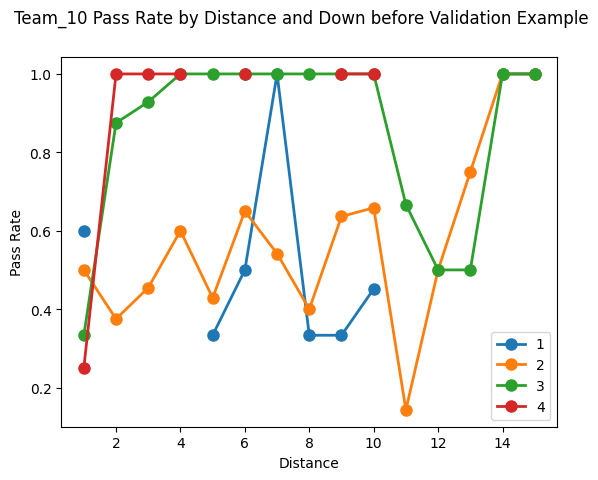

In [77]:
fig, ax = plt.subplots()
team_slice = data.query("OffTeam == 'Team_10' and GAMEID < 19715")
downs = data.DOWN.unique()
distances = np.sort(data.DISTANCE.unique())[0:15]
for down in downs:
    down_df = team_slice[team_slice.DOWN == down]
    y = [down_df.query("DISTANCE == @dist and OffTeam == 'Team_10'").RUNPASS.map({"P":1, "R":0}).mean() for dist in distances]
    ax.plot(distances, y, marker='o', linewidth=2, markersize=8,  label=f"{down}")
    
fig.suptitle("Team_10 Pass Rate by Distance and Down before Validation Example")

plt.legend()
plt.xlabel("Distance")
plt.ylabel("Pass Rate")
plt.savefig("images/results_model_inspection/team_10_pass_rate.png")
plt.show()

In [76]:
data.query("OffTeam == 'Team_10' and GAMEID < 19715 and DISTANCE < 5 and DOWN == 1")

,2MINUTE,CENTERPASSBLOCKDIRECTION,CLOCK,DEFENSIVELINESHIFT,DEFPERSONNEL,DEFSCORE,DEFSUBSTITUTIONS,DefTeam,DEFTIMEOUTSREMAINING,DISTANCE,DOWN,DRIVE,DRIVEENDEVENT,DRIVEENDFIELDPOSITION,DRIVEENDPLAYNUMBER,DRIVEPLAY,DRIVESTARTEVENT,DRIVESTARTFIELDPOSITION,DROPBACKDEPTH,DROPBACKTYPE,FIELDPOSITION,FORCEDFUMBLE,FUMBLE,FUMBLELOST,GAINLOSS,GAINLOSSNET,GAMEID,GARBAGETIME,HASH,HASHDEF,HIT,HURRY,INTERCEPTION,KICKYARDS,MOFOCPLAYED,MOFOCSHOWN,NEXTPLAYID,NOHUDDLE,NOPLAY,OFFFORMATIONUNBALANCED,OFFPERSONNELBASIC,OFFSCORE,OFFSUBSTITUTIONS,OffTeam,OFFTIMEOUTSREMAINING,OPERATIONTIME,OPTION,PASSBREAKUP,PASSDEPTH,PASSDIRECTION,PASSRECEIVERPOSITIONTARGET,PASSRESULT,PASSRUSHRESULT,PASSWIDTH,PENALTY,PENALTYYARDS,PISTOL,PLAYACTION,PLAYACTIONFAKE,PLAYCLOCK,PLAYENDFIELDPOSITION,PLAYID,POAACTUAL,POAINTENDED,PREVIOUSPFFPLAYID,PUMPFAKE,QBMOVEDOFFSPOT,QBPRESSURE,QBRESET,QUARTER,RBDIRECTION,RBSINBACKFIELD,RETURNYARDS,RUNPASS,RUNPASSOPTION,SACK,SCORE,SCOREDIFFERENTIAL,SCREEN,SHIFTMOTION,SHOTGUN,SNAPTIME,SORTORDER,SPOTLEFT,STUNT,TACKLE,TEALIGNMENT,TEMPO,TIMETOPRESSURE,TIMETOTHROW,TOUCHDOWN,TRICKLOOK,TRICKPLAY,WEEK,YARDSAFTERCATCH,YARDSAFTERCONTACT
5474,0,NaN,01:08,0,3-4-4,0,1,Team_24,3,1,1,2.0,TOUCHDOWN,0.0,12.0,12.0,PUNT - OOB,-20.0,NaN,NaN,1,0,0,0,1.0,1,18621,0,R,L,0,0,0,NaN,O,O,3606211.0,0,0,0,11,3,1,Team_10,2,NaN,0,0,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,0,0,7.0,0,3606203,RG,RG,3606194.0,0,0,0,0,1,R,1.0,NaN,R,0,0,0.03,3,0,1,NaN,NaN,28,29,0,0,R,0,NaN,NaN,1,1,0,6,NaN,0.0
6505,0,R,06:57,0,4-2-5,7,0,Team_20,3,1,1,2.0,TOUCHDOWN,0.0,18.0,18.0,KICKOFF - RETURN,-28.0,5.0,SD,1,0,0,0,1.0,1,18644,0,R,L,0,0,0,NaN,O,O,3646641.0,0,0,0,11,7,0,Team_10,3,NaN,0,0,0.0,L,SLWR,COMPLETE,NaN,13.0,0,NaN,NaN,1,1,5.0,0,3646633,NaN,NaN,3646607.0,0,0,0,0,2,NaN,1.0,NaN,P,0,0,7.07,0,0,1,S,NaN,47,29,0,0,R,0,NaN,1.9,1,1,0,8,1.0,0.0
11795,0,L,02:00,0,4-3-4,14,1,Team_19,3,1,1,3.0,TOUCHDOWN,0.0,10.0,9.0,KICKOFF - RETURN,-44.0,5.0,SD,1,0,0,0,NaN,0,19639,0,L,R,1,0,0,NaN,O,O,4009099.0,0,0,0,12,7,1,Team_10,3,NaN,0,0,3.0,M,RWR,INCOMPLETE,HIT,36.0,0,NaN,NaN,1,1,4.0,1,4009096,NaN,NaN,4009094.0,0,1,1,0,2,NaN,1.0,NaN,P,1,0,7.14,-7,0,1,S,NaN,60,24,0,0,L;R,0,1.3,1.7,0,0,0,2,NaN,NaN
11840,0,NaN,12:45,0,2-4-5,17,1,Team_19,2,1,1,7.0,TOUCHDOWN,0.0,6.0,6.0,FUMBLE,23.0,NaN,NaN,1,0,0,0,1.0,1,19639,0,L,R,0,0,0,NaN,O,O,4009248.0,0,0,0,11,28,1,Team_10,3,NaN,0,0,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,0,0,8.0,0,4009243,LE,LE,4009239.0,0,0,0,0,4,R,1.0,NaN,R,1,0,28.17,11,0,1,S,NaN,114,24,0,0,L;L,0,NaN,NaN,1,0,0,2,NaN,1.0
13563,0,L,04:52,0,2-4-5,10,1,Team_30,3,1,1,6.0,TOUCHDOWN,0.0,4.0,4.0,PUNT - OOB,40.0,0.0,RR,1,0,0,0,1.0,1,19668,0,R,L,0,0,0,NaN,O,O,4076975.0,0,0,0,11,20,1,Team_10,3,NaN,0,0,3.0,R,SRWR,COMPLETE,NaN,52.0,0,NaN,NaN,1,1,1.0,0,4076970,NaN,NaN,4076961.0,0,0,0,0,3,NaN,1.0,NaN,P,1,0,20.10,10,0,1,S,NaN,100,29,0,0,L;R,0,NaN,4.0,1,0,0,4,0.0,0.0


In [62]:
data.query("PLAYID == 4185252 ")

,2MINUTE,CENTERPASSBLOCKDIRECTION,CLOCK,DEFENSIVELINESHIFT,DEFPERSONNEL,DEFSCORE,DEFSUBSTITUTIONS,DefTeam,DEFTIMEOUTSREMAINING,DISTANCE,DOWN,DRIVE,DRIVEENDEVENT,DRIVEENDFIELDPOSITION,DRIVEENDPLAYNUMBER,DRIVEPLAY,DRIVESTARTEVENT,DRIVESTARTFIELDPOSITION,DROPBACKDEPTH,DROPBACKTYPE,FIELDPOSITION,FORCEDFUMBLE,FUMBLE,FUMBLELOST,GAINLOSS,GAINLOSSNET,GAMEID,GARBAGETIME,HASH,HASHDEF,HIT,HURRY,INTERCEPTION,KICKYARDS,MOFOCPLAYED,MOFOCSHOWN,NEXTPLAYID,NOHUDDLE,NOPLAY,OFFFORMATIONUNBALANCED,OFFPERSONNELBASIC,OFFSCORE,OFFSUBSTITUTIONS,OffTeam,OFFTIMEOUTSREMAINING,OPERATIONTIME,OPTION,PASSBREAKUP,PASSDEPTH,PASSDIRECTION,PASSRECEIVERPOSITIONTARGET,PASSRESULT,PASSRUSHRESULT,PASSWIDTH,PENALTY,PENALTYYARDS,PISTOL,PLAYACTION,PLAYACTIONFAKE,PLAYCLOCK,PLAYENDFIELDPOSITION,PLAYID,POAACTUAL,POAINTENDED,PREVIOUSPFFPLAYID,PUMPFAKE,QBMOVEDOFFSPOT,QBPRESSURE,QBRESET,QUARTER,RBDIRECTION,RBSINBACKFIELD,RETURNYARDS,RUNPASS,RUNPASSOPTION,SACK,SCORE,SCOREDIFFERENTIAL,SCREEN,SHIFTMOTION,SHOTGUN,SNAPTIME,SORTORDER,SPOTLEFT,STUNT,TACKLE,TEALIGNMENT,TEMPO,TIMETOPRESSURE,TIMETOTHROW,TOUCHDOWN,TRICKLOOK,TRICKPLAY,WEEK,YARDSAFTERCATCH,YARDSAFTERCONTACT
16007,0,R,04:49,0,4-4-3,21,0,Team_25,3,3,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.0,SD,3,0,0,0,NaN,2,19715,0,L,R,0,0,0,NaN,O,O,4185257.0,0,1,0,11,24,0,Team_10,0,NaN,0,1,6.0,M,LWR,INCOMPLETE,NaN,18.0,1,2.0,NaN,1,1,3.0,1,4185252,NaN,NaN,4185249.0,1,0,0,0,4,NaN,1.0,NaN,P,1,0,21.24,3,0,1,S,NaN,139,24,0,0,L,0,NaN,1.8,0,0,0,8,NaN,NaN


In [ ]:
fig, ax = plt.subplots()

distances = np.sort(validation_set_with_probs.DISTANCE.unique())[0:15]
y = [validation_set_with_probs.query("DISTANCE == @dist").correct.mean() for dist in distances]
ax.plot(distances, y, marker='o', linewidth=2, markersize=8,  label=f"{down}")
    
fig.suptitle("Accuracy by Distance")

plt.legend()
plt.xlabel("Distance")
plt.ylabel("Accuracy")
#plt.savefig("images/pass_rate_by_distances_line_chart.png")
plt.show()